# Generate VAR model and infer the structure

In [48]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import string

# Total number of variables
num_variables = 5 

# Total length of all time series
length = 5000

# VAR(1) coefficients
A = np.array([[0.5, 0.2, 0.4, 0.0, 0.0],
              [0.0, 0.6, 0.0, 0.2, 0.0],
              [0.0, 0.0, 0.7, 0.3, 0.0],
              [0.0, 0.0, 0.0, 0.8, 0.7],
              [0.0, 0.0, 0.0, 0.0, 0.4]])

# Draw graph with weights

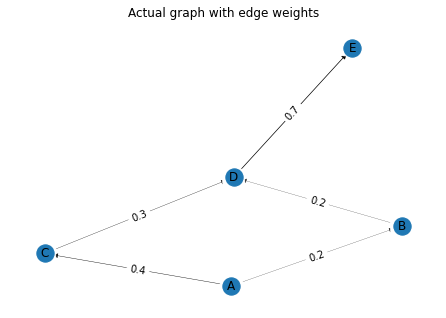

In [49]:
# Node labels, capitals "A", "B", until the num_variables th letter of the alphabet
node_labels = [string.ascii_uppercase[i] for i in range(num_variables)]

# Get nonzero elements and convert to edges
rows, cols = np.where(A > 0)
edges = zip(rows.tolist(), cols.tolist())

# Create directed graph and add edges
gr = nx.DiGraph()
gr.add_edges_from(edges, arrowstyle="->", arrowsize=50)

# Get layout, draw graph
pos = nx.spring_layout(gr)
nx.draw(gr, pos, with_labels=True, labels=dict(zip(range(num_variables), node_labels)), width = A[A > 0])
nx.draw_networkx_edge_labels(gr, pos, edge_labels= dict(zip(zip(rows.tolist(), cols.tolist()), A[A > 0])))

# Show graph
plt.title("Actual graph with edge weights")
plt.show()

# Generate data

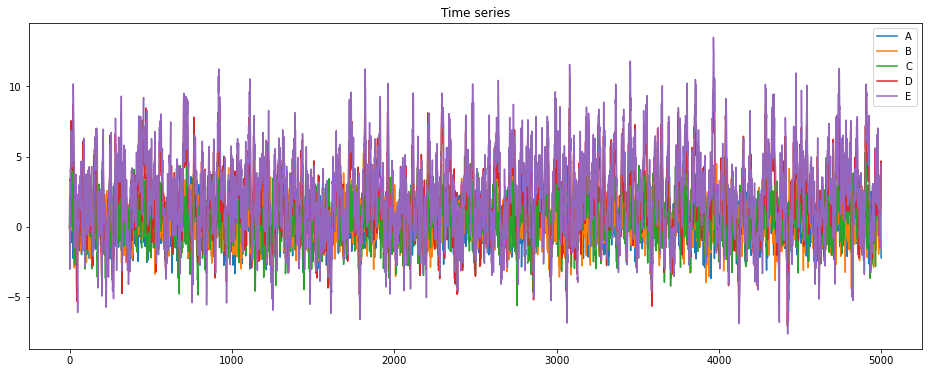

In [50]:
# Get topological ordering to infer time series
gr.remove_edges_from(nx.selfloop_edges(gr))
order = list(nx.dag.topological_sort(gr))

# Initialize series
series = np.array(np.zeros((length, num_variables)))

# Generate series
for node in order:
    # Generate series of this node
    for t in range(1, length):
        # Generate VAR model
        series[t][node] = 0.1 + np.random.normal(0, 1)
        # Add dependencies of other nodes
        for var in order:
            series[t][node] += A[var][node] * series[t-1][var]

# Plot
plt.figure(figsize=(16,6))
plt.title("Time series")
plots = plt.plot(series)
plt.legend(plots, node_labels, loc=1)
plt.show()

# Infer method 1: Fit VAR(1) model and use Granger Causailty

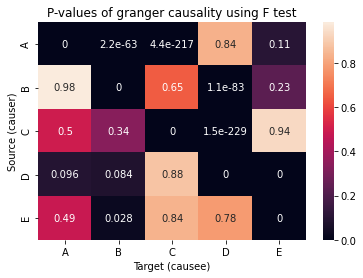

In [53]:
# Import Statsmodels
from statsmodels.tsa.api import VAR
import itertools
import seaborn as sns

# Create model
model = VAR(series)

# Fit model order 1
result = model.fit(1)

signif = 0.02

# Create heapmap
heatmap1 = np.array(np.zeros((5, 5)))
# heatmap2 = np.array(np.zeros((5, 5)))
for a, b in itertools.product(range(5), repeat=2):   
    heatmap1[b][a] = result.test_causality(a, b, signif=signif, kind = "f").pvalue
    # heatmap2[b][a] = result.test_causality(a, b, signif=signif, kind = "wald").pvalue

# Plot heatmap based on conclusion
heatmap_plot = sns.heatmap(heatmap1,xticklabels="ABCDE", yticklabels="ABCDE", annot=True)
heatmap_plot.set(xlabel="Target (causee)", ylabel="Source (causer)")
plt.title("P-values of granger causality using F test")
plt.show()

# Plot heatmap based on conclusion
# heatmap_plot = sns.heatmap(heatmap2,xticklabels="ABCDE", yticklabels="ABCDE", annot=True)
# heatmap_plot.set(xlabel="Target (causee)", ylabel="Source (causer)")
# plt.title("P-values of granger causality using Wald test")
# plt.show()

# Draw Inferred graph

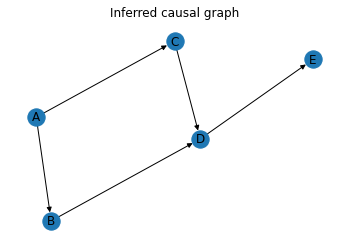

In [54]:
# Draw graph
rows, cols = np.where(heatmap1 < signif)
edges = zip(rows.tolist(), cols.tolist())

gr = nx.DiGraph()
gr.add_edges_from(edges, arrowstyle="->", arrowsize=10,)
plt.title("Inferred causal graph")
nx.draw(gr, with_labels=True, labels=dict(zip(range(num_variables), node_labels)))

# Method 2: LASSO

In [55]:
import scipy

# Other approach: Minimize the two-norm plus some regularizer
def f(A, l = 50):
    B = A.reshape((5,5))
    cost = 0
    for t in range(1, length):
        cost += np.linalg.norm((series[t] - np.matmul(B, series[t-1]))) ** 2
    return cost + l * sum(np.absolute(A))

def callbackF(Xi):
    global nEval
    print('eval_number: {0:4d}, ..., '.format(nEval), end="")
    nEval += 1

nEval = 0

min_results = scipy.optimize.minimize(f, np.ones(25), callback=callbackF)

eval_number:    0, ..., eval_number:    1, ..., eval_number:    2, ..., eval_number:    3, ..., eval_number:    4, ..., eval_number:    5, ..., eval_number:    6, ..., eval_number:    7, ..., eval_number:    8, ..., eval_number:    9, ..., eval_number:   10, ..., eval_number:   11, ..., eval_number:   12, ..., eval_number:   13, ..., eval_number:   14, ..., eval_number:   15, ..., eval_number:   16, ..., eval_number:   17, ..., eval_number:   18, ..., eval_number:   19, ..., eval_number:   20, ..., eval_number:   21, ..., eval_number:   22, ..., eval_number:   23, ..., eval_number:   24, ..., eval_number:   25, ..., eval_number:   26, ..., eval_number:   27, ..., eval_number:   28, ..., eval_number:   29, ..., eval_number:   30, ..., eval_number:   31, ..., eval_number:   32, ..., eval_number:   33, ..., eval_number:   34, ..., eval_number:   35, ..., eval_number:   36, ..., eval_number:   37, ..., eval_number:   38, ..., eval_number:   39, ..., eval_number:   40, ..., eval_number:   4

In [47]:
print(np.round(min_results.x, 1).reshape((5,5)).transpose())

[[ 0.4  0.2  0.4  0.  -0. ]
 [-0.   0.6  0.   0.1  0. ]
 [-0.  -0.   0.7  0.3  0. ]
 [ 0.   0.  -0.   0.8  0.7]
 [ 0.   0.  -0.   0.   0.4]]
